In [1]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Reshape, Permute, Activation, BatchNormalization, \
    Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# validation keras fix 
# ref: http://stackoverflow.com/questions/41796618/python-keras-cross-val-score-error/41841066#41841066
from keras.wrappers.scikit_learn import BaseWrapper
import copy

def custom_get_params(self, **params):
    res = copy.deepcopy(self.sk_params)
    res.update({'build_fn': self.build_fn})
    return res

BaseWrapper.get_params = custom_get_params


In [16]:
# load data
Xtrain = np.load('./data/dataset64/Xtrain.npy')
Xtest = np.load('./data/dataset64/Xtest.npy')
Ytrain = np.load('./data/dataset64/Ytrain.npy')
Ytest = np.load('./data/dataset64/Ytest.npy')

In [4]:
# netowrk settings
batch_size = 128
nb_epoch = 5

In [5]:
def MyNet():
    model = Sequential()
    model.add(Convolution2D(8, 5, 5, border_mode='same', input_shape=(64, 64,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(16, 3, 3))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(32, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    
    return model


In [6]:
model = MyNet()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 64, 64, 8)     608         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 64, 64, 8)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 64, 64, 8)     32          activation_1[0][0]               
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 32, 8)     0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [7]:
# batch logger 
# ref: https://github.com/fchollet/keras/issues/2850#issuecomment-222542429
class NBatchLogger(Callback):
    def __init__(self,display=100):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.display = display

    def on_batch_end(self,batch,logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0:
            print('\n{0}/{1} - Batch Loss: {2}'.format(self.seen,self.params['nb_sample'],
                                                self.params['metrics'][0]))

In [10]:
#train just 1000 samples, 3 epochs
# if False:
checkpoint = ModelCheckpoint(filepath='./training-checkpoint/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5')
out_batch = NBatchLogger(display=1)
history = model.fit(x=Xtrain[:1000], y=Ytrain[:1000], 
          nb_epoch=nb_epoch, batch_size=batch_size,validation_split=0.1, verbose=1, callbacks=[checkpoint, out_batch]) 

Train on 900 samples, validate on 100 samples
Epoch 1/5

128/900 - Batch Loss: loss
128/900 [===>..........................] - ETA: 17s - loss: 2.1667
256/900 - Batch Loss: loss
256/900 [=======>......................] - ETA: 9s - loss: 4.0477 
384/900 - Batch Loss: loss
384/900 [===========>..................] - ETA: 6s - loss: 3.2048
512/900 - Batch Loss: loss
512/900 [================>.............] - ETA: 4s - loss: 3.0973
640/900 - Batch Loss: loss
640/900 [====================>.........] - ETA: 2s - loss: 2.8785
768/900 - Batch Loss: loss
768/900 [========================>.....] - ETA: 1s - loss: 2.6843
896/900 - Batch Loss: loss
896/900 [============================>.] - ETA: 0s - loss: 2.5290
900/900 - Batch Loss: loss
900/900 [==============================] - 10s - loss: 2.5205 - val_loss: 0.6075
Epoch 2/5

1028/900 - Batch Loss: loss
128/900 [===>..........................] - ETA: 5s - loss: 4.3158
1156/900 - Batch Loss: loss
256/900 [=======>......................] - ETA: 4

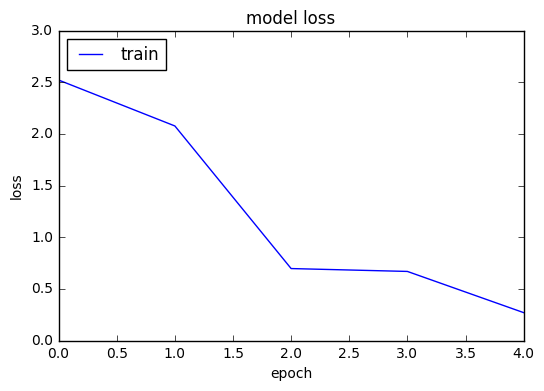

In [15]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [13]:
model.evaluate(x=Xtest, y=Ytest,batch_size=batch_size)

3852/3852 [==============================] - 9s     


0.87027442789523402

In [ ]:
# regression 
# rev: http://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [8]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=MyNet, nb_epoch=nb_epoch, batch_size=batch_size, verbose=1)

In [9]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, Xtrain[:1000], Ytrain[:1000], cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/5
900/900 [==============================] - 7s - loss: 2.2799     
Epoch 2/5
900/900 [==============================] - 6s - loss: 1.4239     
Epoch 3/5
900/900 [==============================] - 6s - loss: 0.7362     
Epoch 4/5
900/900 [==============================] - 6s - loss: 0.5345     
Epoch 5/5
100/100 [==============================] - 0s
Epoch 1/5
900/900 [==============================] - 8s - loss: 1.7907     
Epoch 2/5
900/900 [==============================] - 6s - loss: 3.7076     
Epoch 3/5
900/900 [==============================] - 6s - loss: 0.6714     
Epoch 4/5
900/900 [==============================] - 7s - loss: 0.3546     
Epoch 5/5
100/100 [==============================] - 0s
Epoch 1/5
900/900 [==============================] - 8s - loss: 1.9293     
Epoch 2/5
900/900 [==============================] - 6s - loss: 1.5638     
Epoch 3/5
900/900 [==============================] - 6s - loss: 0.6591     
Epoch 4/5
900/900 [==============================] -

In [ ]:
model.